## Master in Artificial Intelligence, USC, UDC, UVigo. 2023/2024
## COMPUTER VISION I 

### Topic 4: Image Segmentation   
### Part 1: intensity-based thresholding and clustering

#### Histogram thresholding

**Exercise 1:**
Read and visualize 'plates.png', and:
1. Calculate its histogram, and visualize it using matplotlib and pyplot (1_intro_CV notebook).   
2. Do the same using the “seaborn” package.   
3. Compute a smoothed version of the histogram by using KDE from the “seaborn” package.   

In [1]:
images_path = './datasets/images/'

In [2]:
import cv2
import sys

In [3]:
# needed later...
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn import mixture
from sklearn.cluster import KMeans
from sklearn.cluster import MeanShift, estimate_bandwidth
from scipy.stats import norm
from sklearn.cluster import DBSCAN

In [4]:
im_plates = cv2.imread(images_path + 'plates.png', cv2.IMREAD_GRAYSCALE)
if im_plates is None:
    sys.exit('Input image not found, check the path')

In [5]:
# display it with cv2, close image when done with visualization
cv2.imshow('image', im_plates)
k = cv2.waitKey(0)    
if k == ord('q'):         # wait for 'q' key to quit
    cv2.destroyAllWindows()

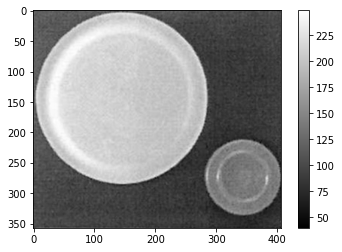

In [6]:
# or display it here with pyplot
plt.imshow(im_plates, cmap='gray')
plt.colorbar()

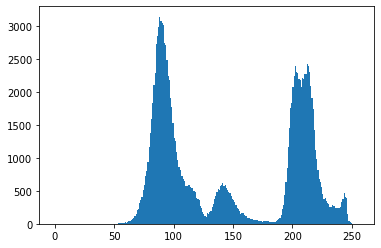

In [7]:
# 1. Calculate its histogram and visualize it using matplotlib and pyplot  

# usage: matplotlib.pyplot.hist(x, bins=None, range=None, density=False, weights=None, cumulative=False, bottom=None, histtype='bar', 
#                               align='mid', orientation='vertical', rwidth=None, log=False, color=None, label=None, stacked=False, *, 
#                               data=None, **kwargs)

#plt.hist(im_plates.ravel(), 256, [0,256])    
plt.hist(im_plates.reshape(-1), 256, [0,256])  
plt.show()

<AxesSubplot:ylabel='Count'>

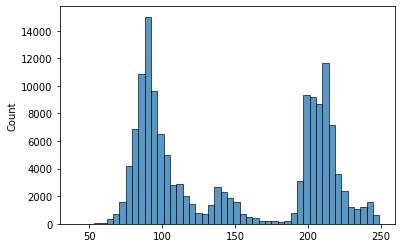

In [8]:
# 2. Do the same using the “seaborn” package   
sns.histplot(im_plates.reshape(-1))

<AxesSubplot:ylabel='Count'>

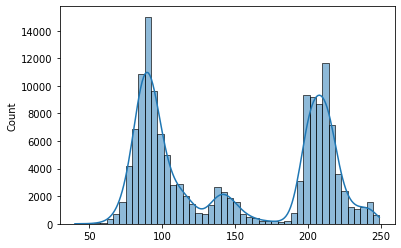

In [9]:
# 3. Compute a smoothed version of the histogram by using KDE from the “seaborn” package   
sns.histplot(im_plates.reshape(-1), kde=True)

<AxesSubplot:ylabel='Density'>

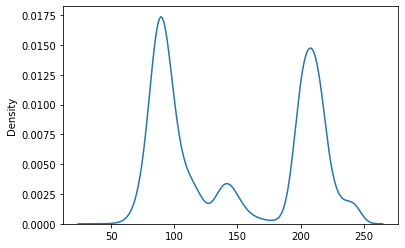

In [10]:
sns.kdeplot(im_plates.reshape(-1))       # only kde

**Exercise 2:**
Apply multilevel thresholding to 'plates.png'.   
1. What is the optimal number of levels?
2. How does the histogram change?

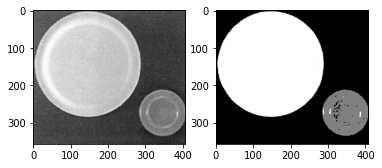

In [11]:
im_plates_out = im_plates.copy()
im_plates_out[np.where(im_plates < 130)] = 0
im_plates_out[np.where((im_plates >= 130) & (im_plates < 180))] = 50
im_plates_out[np.where(im_plates >= 180)] = 100

fig, ax = plt.subplots(1, 2)
ax[0].imshow(im_plates, cmap='gray')
ax[1].imshow(im_plates_out, cmap='gray')

<AxesSubplot:ylabel='Count'>

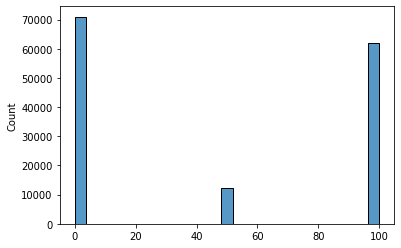

In [12]:
sns.histplot(im_plates_out.reshape(-1))

**Exercise 3:**
Read and visualize the image 'avocado.png', and:
1. Check the bimodal distribuition of the pixels.
2. What intensity threshold would you use to segment the avocado?
3. Segment it using the Otsu method. What is the estimated optimal threshold?

Min and max pixel value =  4 , 255


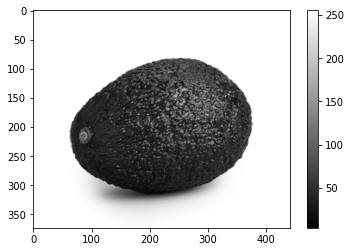

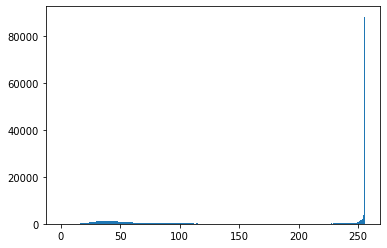

In [13]:
im_av = cv2.imread(images_path + 'avocado.png', cv2.IMREAD_GRAYSCALE)

if im_av is None:
    sys.exit('Input image not found, check the path')

print('Min and max pixel value = ', np.min(im_av), ',' , np.max(im_av))
plt.imshow(im_av, cmap='gray')
plt.colorbar()
plt.figure()
plt.hist(im_av.reshape(-1), 256, [0, 256]) 
plt.show()

Estimated optimal threshold = 153.0


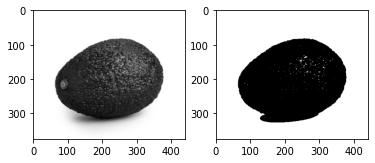

In [14]:
# Otsu's thresholding
thresh, im_av_otsu = cv2.threshold(im_av, 0, 255, cv2.THRESH_OTSU)
print('Estimated optimal threshold =', thresh)
fig, ax = plt.subplots(1,2)
ax[0].imshow(im_av, cmap='gray')
ax[1].imshow(im_av_otsu, cmap='gray')

**Exercise 4:**
Read and visualize the image 'CT.png', and:
1. Inspect the intensity distribution of the pixels.
2. What intensity threshold would you use to segment the lungs?
3. Try to segment the lungs using the Otsu method. What is the estimated optimal threshold?

Min and max pixel value =  0 , 198


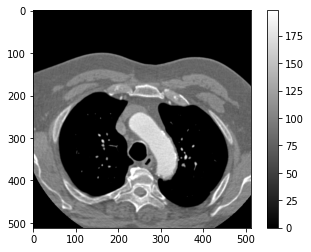

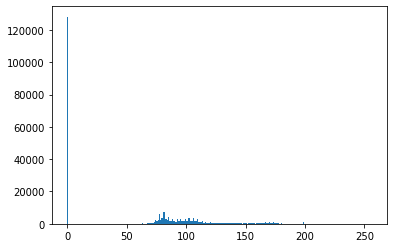

In [15]:
im_ct = cv2.imread(images_path + 'CT.png', cv2.IMREAD_GRAYSCALE)

if im_ct is None:
    sys.exit('Input image not found, check the path')

print('Min and max pixel value = ', np.min(im_ct), ',' , np.max(im_ct))
plt.imshow(im_ct, cmap='gray')
plt.colorbar()
plt.figure()
plt.hist(im_ct.reshape(-1), 256, [0, 256]) 
plt.show()

Estimated optimal threshold = 51.0


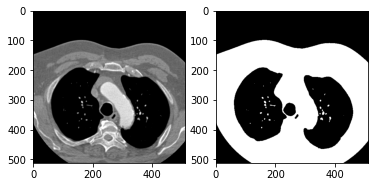

In [16]:
# Otsu's thresholding
thresh, im_ct_otsu = cv2.threshold(im_ct, 0, 255, cv2.THRESH_OTSU)
print('Estimated optimal threshold =', thresh)
fig, ax = plt.subplots(1, 2)
ax[0].imshow(im_ct, cmap='gray')
ax[1].imshow(im_ct_otsu, cmap='gray')

**Exercise 5:** Using the auxiliary functions provided next:
1. Apply the Gaussian Mixture Model (GMM) method (e.g. the implementation in scikit-learn) to 'CT.png' to segment **other parts** of the image. First exclude the background and lungs and try different number of Gaussians.
3. Would it be possible to additionally segment the bones (whitest parts)?

In [17]:
# Auxiliary functions

def fit_GMM(im, nb_gaussians, plot_stds=False):
    """ Fit GMM given the desired nb of Gaussians """

    gmm = mixture.GaussianMixture(n_components=nb_gaussians, max_iter=1000, covariance_type='full', random_state=1).fit(im.reshape(-1, 1))
    ordered_mu, ordered_std, ordered_pi, order = find_GMM_statistics(gmm)
    gaussian_colors = ['b','g','r','c','m','y']    # max 6 gaussians, add more if necessary
    print('Means = ', ordered_mu)
    print('Stds = ', ordered_std)
    print('Pis = ', ordered_pi)
    for i in range(nb_gaussians):
        plot_gaussian_and_stds(np.array([np.min(im), np.max(im)]), ordered_mu[i], ordered_std[i], ordered_pi[i], gaussian_colors[i], plot_stds, alpha=0.8)
    
    return gmm, ordered_mu, ordered_std, ordered_pi, order

def find_GMM_statistics(gmm):
    """ Determine which one is the first (lower mean), the second, the third, etc., Gaussian to consistently color them in the plots, 
    visualize the masks, etc. """

    all_means = np.array(gmm.means_[:, 0]).flatten()
    all_covariances = gmm.covariances_.flatten()

    order = np.argsort(all_means)  # this is also the label of clusters, return also 'order', useful to modify the cluster's label if necessary
    ordered_mu = all_means[order]
    ordered_std = np.sqrt(all_covariances[order])
    ordered_pi = gmm.weights_[order]

    return ordered_mu, ordered_std, ordered_pi, order

def plot_gaussian_and_stds(gaussians_range, mu, std, pi, color, plot_stds=False, alpha=1):
    """ Plot the Gaussian given by mu, std and pi. If plot_stds, additionally plot vertical lines corresponding to +-1SD, +-2SD, +-3SD"""

    xmin, xmax = gaussians_range
    x = np.linspace(xmin, xmax, 1000)
    p = norm.pdf(x, mu, std) * pi
    if plot_stds:
        # plt.axvline(mu + std, 0, 1, label='pyplot vertical line', c=color)
        plt.axvline(mu + std, 0, 1, c=color, ls='--', alpha=0.75)
        plt.axvline(mu - std, 0, 1, c=color, ls='--', alpha=0.75)
    
        plt.axvline(mu + 2 * std, 0, 1, c=color, ls='-.', alpha=0.5)
        plt.axvline(mu - 2 * std, 0, 1, c=color, ls='-.', alpha=0.5)
    
        plt.axvline(mu + 3 * std, 0, 1, c=color, ls=':', alpha=0.25)
        plt.axvline(mu - 3 * std, 0, 1, c=color, ls=':', alpha=0.25)
    
    plt.plot(x, p, color, linewidth=2, alpha=alpha,
             label="Mean = {:.2f}; STD = {:.2f}; Weight = {:.2f}".format(mu, std, pi))

Means =  [ 91.82286521 157.87938665]
Stds =  [14.09729999 19.91307259]
Pis =  [0.83708186 0.16291814]
Means =  [ 81.16461075 103.98387022 158.38339534]
Stds =  [ 7.04149316  9.32615046 19.28658287]
Pis =  [0.44704646 0.39114937 0.16180417]
Means =  [ 81.29708053 103.36791435 129.31392959 167.83064793]
Stds =  [ 6.97400384  7.18309719 11.19307727 13.17618905]
Pis =  [0.46337003 0.3435808  0.07790791 0.11514125]


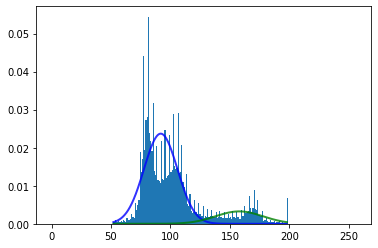

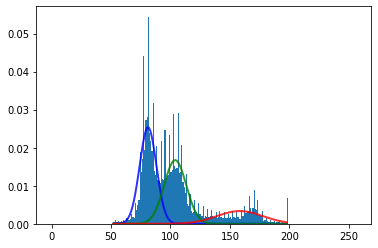

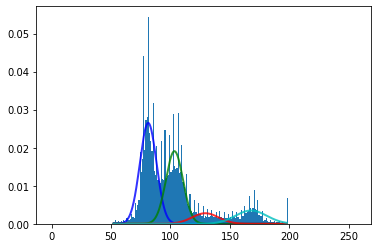

In [20]:
other_colors = im_ct[np.where(im_ct_otsu==255)]      # exclude background and lungs
plt.hist(other_colors.reshape(-1), 256, [0, 256], density=True)    # density for probability density instead of total count 

gmm, ordered_mu, ordered_std, ordered_pi, order = fit_GMM(other_colors, nb_gaussians=2, plot_stds=False)

plt.figure()
plt.hist(other_colors.reshape(-1), 256, [0, 256], density=True)
gmm, ordered_mu, ordered_std, ordered_pi, order = fit_GMM(other_colors, nb_gaussians=3, plot_stds=False)

plt.figure()
plt.hist(other_colors.reshape(-1), 256, [0, 256], density=True)
gmm, ordered_mu, ordered_std, ordered_pi, order = fit_GMM(other_colors, nb_gaussians=4, plot_stds=False)

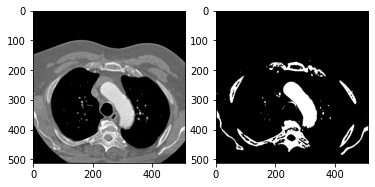

In [21]:
threshold = 120

bones_mask = np.zeros_like(im_ct)
bones_mask[np.where(im_ct > threshold)] = 1

fig, ax = plt.subplots(1, 2)
ax[0].imshow(im_ct, cmap='gray')
ax[1].imshow(bones_mask, cmap='gray')

#### Clustering

**Exercise 6:** Using 'CT.png':
1. Try **several times** k-means specifying different number of clusters.
2. What differences, if any, do you observe between each run?

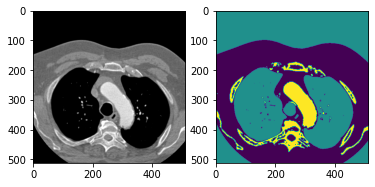

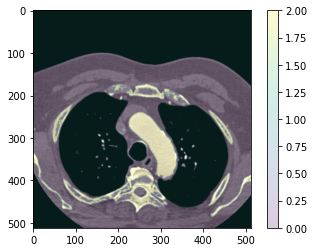

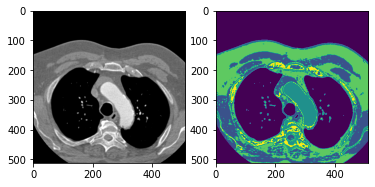

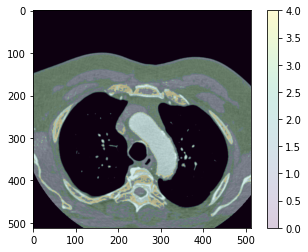

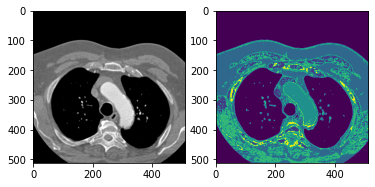

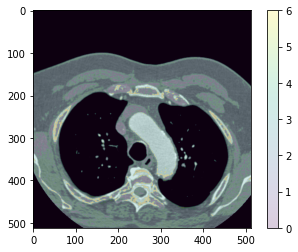

In [22]:
# Using the scikit-learn library
n = 3      # nb of clusters

# Run 1
kmeans = KMeans(n_clusters=n, n_init="auto").fit(im_ct.reshape(-1, 1))
fig, ax = plt.subplots(1, 2)
ax[0].imshow(im_ct, cmap='gray')
ax[1].imshow(kmeans.labels_.reshape(im_ct.shape))

# plot image + labels overlayed
plt.figure()
plt.imshow(im_ct, cmap='gray')
plt.imshow(kmeans.labels_.reshape(im_ct.shape), alpha=0.2)
plt.colorbar()

n=5
# Run 2
kmeans = KMeans(n_clusters=n, n_init="auto").fit(im_ct.reshape(-1, 1))
fig, ax = plt.subplots(1, 2)
ax[0].imshow(im_ct, cmap='gray')
ax[1].imshow(kmeans.labels_.reshape(im_ct.shape))

plt.figure()
plt.imshow(im_ct, cmap='gray')
plt.imshow(kmeans.labels_.reshape(im_ct.shape), alpha=0.2)
plt.colorbar()

n=7
# Run 3
kmeans = KMeans(n_clusters=n, n_init="auto").fit(im_ct.reshape(-1, 1))
fig, ax = plt.subplots(1, 2)
ax[0].imshow(im_ct, cmap='gray')
ax[1].imshow(kmeans.labels_.reshape(im_ct.shape))

plt.figure()
plt.imshow(im_ct, cmap='gray')
plt.imshow(kmeans.labels_.reshape(im_ct.shape), alpha=0.2)
plt.colorbar()

**Exercise 7:** Read and visualize 'puncher.png' and its corresponding histogram. Then:   
1. Apply k-means to segment the object.
2. Apply Meanshift to segment the object. Try different 'bandwidth' values.  

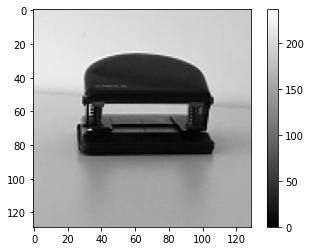

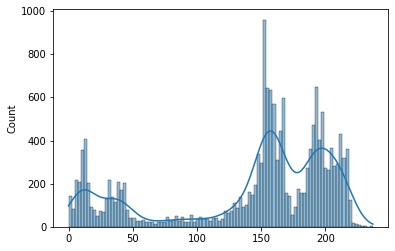

In [23]:
im_pun = cv2.imread(images_path + 'puncher.png', cv2.IMREAD_GRAYSCALE)
if im_pun is None:
    sys.exit('Input image not found, check the path')

plt.imshow(im_pun, cmap='gray')
plt.colorbar()
plt.figure()
sns.histplot(im_pun.reshape(-1), bins=100, kde=True)
plt.show()

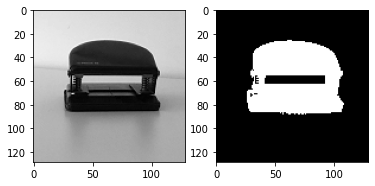

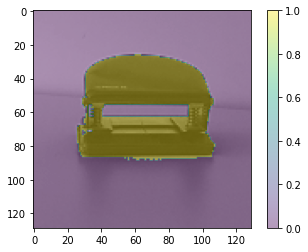

In [ ]:
kmeans = KMeans(n_clusters=2, n_init="auto").fit(im_pun.reshape(-1, 1))
fig, ax = plt.subplots(1, 2)
ax[0].imshow(im_pun, cmap='gray')
ax[1].imshow(kmeans.labels_.reshape(im_pun.shape), cmap='gray')

plt.figure()
plt.imshow(im_pun, cmap='gray')
plt.imshow(kmeans.labels_.reshape(im_pun.shape), alpha=0.4)
plt.colorbar()

In [24]:
# Meanshift with default bandwidth
ms_default = MeanShift().fit(im_pun.reshape(-1, 1))   

Found 2 clusters


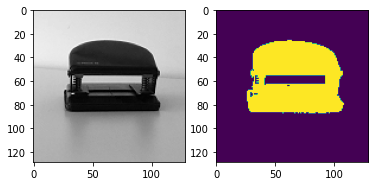

In [25]:
print('Found', len(np.unique(ms_default.labels_)), 'clusters')
fig, ax = plt.subplots(1, 2)
ax[0].imshow(im_pun, cmap='gray')
ax[1].imshow(ms_default.labels_.reshape(im_pun.shape))

In [26]:
# different bandwidth
ms_10 = MeanShift(bandwidth=10).fit(im_pun.reshape(-1, 1))

Found 8 clusters


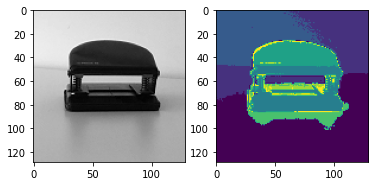

In [27]:
print('Found', len(np.unique(ms_10.labels_)), 'clusters')
fig, ax = plt.subplots(1, 2)
ax[0].imshow(im_pun, 'gray')
ax[1].imshow(ms_10.labels_.reshape(im_pun.shape))

#### Assigment

**Exercise 8:**
Read and visualize the image 'fieldWheat.png', and use k-means (with number of clusters = 3) to segment:
1. The field of wheat alone. Save the resulting image.
2. The whole sky (clear sky and clouds)   
**Note 1:** if more than 1 feature (e.g. 'R', 'G', and 'B' in a color image), each feature should be given as a column.   
**Note 2:** remember that different initialization may lead to different clusters.

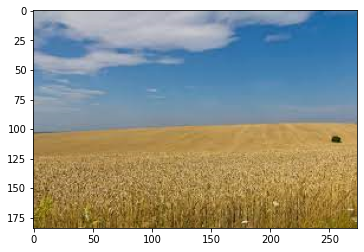

In [28]:
im_field = cv2.imread(images_path + 'field.png')      # cv2 reads it BGR order
if im_field is None:
    sys.exit('Input image not found, check the path')

plt.imshow(im_field[...,::-1])   # IMPORTANT --> matplotlib requires RGB order
plt.show()

In [29]:
X = np.array([im_field[:, :, 0].reshape(-1), im_field[:, :, 1].reshape(-1), im_field[:, :, 2].reshape(-1)]).T
print(X.shape)

(50416, 3)


[[ 71.12196688 133.33020927 165.46227586]
 [177.76606249 159.86134424 143.96565343]
 [174.48811189 128.56588967  73.01763792]]


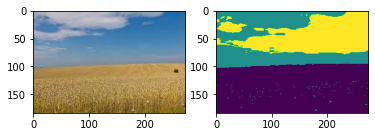

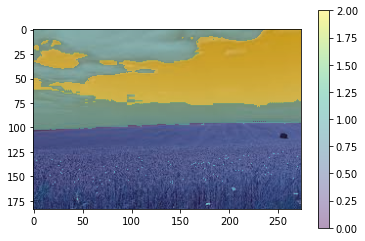

In [30]:
kmeans = KMeans(n_clusters=3, n_init="auto").fit(X)
im_field_kmeans_labels = kmeans.labels_.reshape([im_field.shape[0], im_field.shape[1]])
fig, ax = plt.subplots(1, 2)
ax[0].imshow(im_field[...,::-1])  
ax[1].imshow(im_field_kmeans_labels)

plt.figure()
plt.imshow(im_field)
plt.imshow(im_field_kmeans_labels, alpha=0.4)
plt.colorbar()

print(kmeans.cluster_centers_)

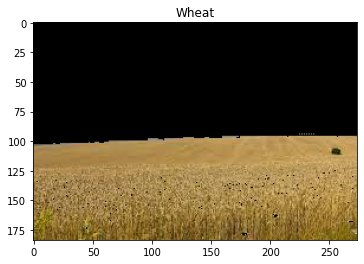

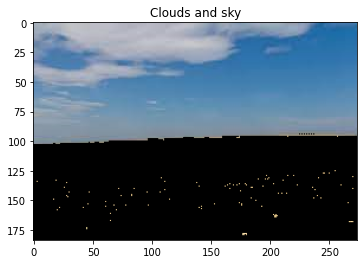

In [94]:
## YOUR CODE

#Mask for wheat
cluster_0_mask = (im_field_kmeans_labels == 0)

#Apply mask
im_field_cluster_0 = np.zeros_like(im_field)
im_field_cluster_0[cluster_0_mask] = im_field[cluster_0_mask]
cv2.imwrite(images_path+'wheat.jpg',im_field_cluster_0)

#Mask for clouds
cluster_1_mask = (im_field_kmeans_labels == 1)

#Mask for sky
cluster_2_mask = (im_field_kmeans_labels == 2)

#Mask for clouds and sky
cluster_2_mask+=cluster_1_mask

#Apply mask
im_field_cluster_2 = np.zeros_like(im_field)
im_field_cluster_2[cluster_2_mask] = im_field[cluster_2_mask]
cv2.imwrite(images_path+'cloud_sky.jpg',im_field_cluster_2)

#Show images
plt.figure()
plt.imshow(cv2.cvtColor(im_field_cluster_0, cv2.COLOR_BGR2RGB))
plt.title('Wheat')
plt.show()

plt.figure()
plt.imshow(cv2.cvtColor(im_field_cluster_2, cv2.COLOR_BGR2RGB))
plt.title('Clouds and sky')
plt.show()


**Exercise 9: Density-based clustering**   
1. Load 'matrix.dat' data (data generated with 1 run of the code showed next).
2. Apply DBSCAN to segment the 2 clearest custers only.

In [ ]:
# Generate dataset
# X = np.concatenate((
#     np.random.normal(0, 10, (50, 2)),    # loc, scale, size. This one, noise-like 
#     np.random.normal(3, 1, (250, 2)),
#     np.random.normal(10, 1, (400, 2))))


# X = np.concatenate((
#     np.random.normal(0, 10, (50, 2)),    # loc, scale, size. This one, noise-like 
#     np.random.normal(3, 1, (250, 2)),
#     np.random.normal(10, 1, (400, 2)),
#     np.random.normal(-10, 2, (100, 2))))


# # save it
# X.dump("other_matrix.dat")

Text(0.5, 1.0, 'Data')

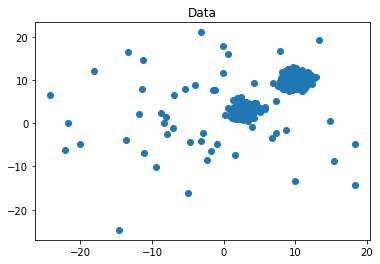

In [46]:
X = np.load("datasets/matrix.dat", allow_pickle=True)
plt.scatter(X[:, 0], X[:, 1])
plt.title("Data")

/home/martin/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Text(0.5, 1.0, 'K Means Clustering')

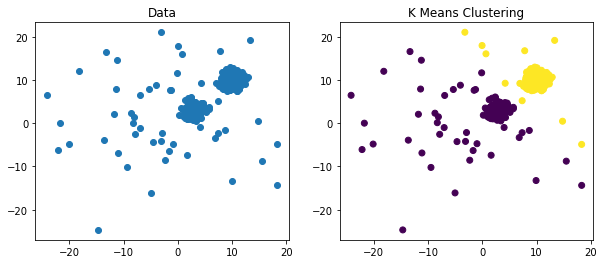

In [47]:
# Show what k-means can do...
kmeans = KMeans(n_clusters=2, random_state=42)
kmeans_labels = kmeans.fit_predict(X)

fig, ax = plt.subplots(ncols=2, figsize=(10, 4))
ax[0].scatter(X[:, 0], X[:, 1])
ax[0].set_title("Data")

ax[1].scatter(X[:, 0], X[:, 1], c=kmeans_labels)
ax[1].set_title("K Means Clustering")

Found 2 clusters: [-1  0  1]
Found 5 clusters: [-1  0  1  2  3  4]
Found 2 clusters: [-1  0  1]


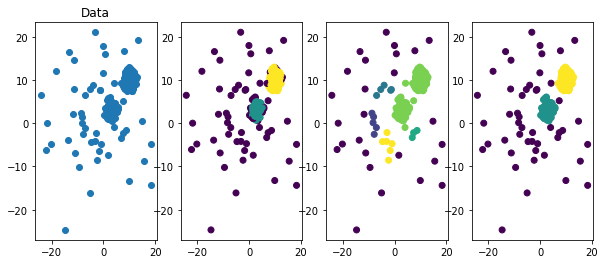

In [107]:
# Density-based clustering with DBSCAN

clustering1 = DBSCAN().fit(X)      # default eps = 0.5, min_samples=5
print('Found', len(np.unique(clustering1.labels_))-1, 'clusters:', np.unique(clustering1.labels_))

clustering2 = DBSCAN(eps=3, min_samples=3).fit(X)    
print('Found', len(np.unique(clustering2.labels_))-1, 'clusters:', np.unique(clustering2.labels_))

# your bet:
clustering3 = DBSCAN(eps=1.5, min_samples=9).fit(X)    
print('Found', len(np.unique(clustering3.labels_))-1, 'clusters:', np.unique(clustering3.labels_))

fig, ax = plt.subplots(ncols=4, figsize=(10, 4))

ax[0].scatter(X[:, 0], X[:, 1])
ax[0].set_title("Data")

ax[1].scatter(X[:, 0], X[:, 1], c=clustering1.labels_)
ax[2].scatter(X[:, 0], X[:, 1], c=clustering2.labels_)
ax[3].scatter(X[:, 0], X[:, 1], c=clustering3.labels_)
